# Imports and setup

In [1]:
import os
import time
from UTILITY_quickstart import *

## Define plotting helpers

In [2]:
formatter = plt.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))

key_label_dict = {
    'energy'             : 'Mean energy [GeV]',
    'peak current 50'    : 'Peak current (50 bins) [kA]',
    'peak current 100'   : 'Peak current (100 bins) [kA]',
    'peak current 200'   : 'Peak current (200 bins) [kA]',
    'sigma_x'            : r'RMS horizontal spot size [$\mu m$]',
    'sigma_y'            : r'RMS vertical spot size [$\mu m$]',
    'sigma_z'            : r'RMS bunch length [$\mu m$]',
    'emittance_x'        : r'Normalized $\varepsilon_x$ [$\mu m$]',
    'emittance_y'        : r'Normalized $\varepsilon_y$ [$\mu m$]',
    'pmd_emittance_x'    : r'Built-in pmd normalized $\varepsilon_x$ [$\mu m$]',
    'pmd_emittance_y'    : r'Built-in pmd normalized $\varepsilon_y$ [$\mu m$]',
    'energy spread'      : r'Energy spread [%]',
}

key_scale_dict = {
    'energy'             : 1e-9,
    'peak current 50'    : 1e-3,
    'peak current 100'   : 1e-3,
    'peak current 200'   : 1e-3,
    'sigma_x'            : 1e6,
    'sigma_y'            : 1e6,
    'sigma_z'            : 1e6,
    'emittance_x'        : 1e6,
    'emittance_y'        : 1e6,
    'pmd_emittance_x'    : 1e6,
    'pmd_emittance_y'    : 1e6,
    'energy spread'      : 1e2,
}


def TDRBoxPlot(val, positions=None, widths=None):
    boxprops     = dict(color='b')
    medianprops  = dict(color='r')
    flierprops   = dict(markeredgecolor='r', marker='+')
    whiskerprops = dict(linestyle='--')
    
    plt.boxplot(val,
                notch=True,
                boxprops=boxprops,
                medianprops=medianprops,
                flierprops=flierprops,
                whiskerprops=whiskerprops,
                positions=positions,
                widths=widths
               )
    return

def sci():
    ax=plt.gca()
    ax.yaxis.set_major_formatter(formatter)
    return

## Combine beam diagnostics at given location

In [3]:
def gather_diagnostics(location: str) -> list:
    return [ diagnostics[xopt_out['Unique ID'].iloc[i]][location][key]*key_scale_dict[key] for i in range(len(diagnostics)) ]
    # return [ diagnostics[jitter_numbers['Unique ID'].iloc[i]][location][key]*key_scale_dict[key] for i in range(jitter_numbers.index.stop) ]
    # return [ diagnostics[uid][location][key]*key_scale_dict[key] for uid in diagnostics.keys() ]

## Gather unique ID's

In [4]:
def gather_UID(path: str) -> list:
    return [ f.name for f in os.scandir(path) if f.is_dir() and f.name != 'beams' ]

# Initialize and extract data

In [4]:
directory = '/pscratch/sd/m/maxvarv/Jitter_2025_02_25/9x_6hr_L2_Phase'
# uids = gather_UID(directory)
# jitter_numbers = pd.read_csv(f'{directory}/jitter_numbers.csv')
# xopt_out = pd.read_csv(f'{directory}/xopt_out.csv')
xopt_out = pd.concat([ pd.read_csv(f'{directory}/xopt_out_{i}.csv') for i in range(9)] , ignore_index=True)

# filter out any incomplete sims
xopt_out = xopt_out[xopt_out['xopt_error'] == False]

# extract beam diagnostics from each run by the unique ID
diagnostics = {}
# for uid in jitter_numbers['Unique ID']:
for uid in xopt_out['Unique ID']:
# for uid in uids:
    try:
        diagnostics[uid] = pd.read_csv(f'{directory}/{uid}/diagnostics.csv', index_col=0)
    except:
        print(f'{uid} not imported!')


%time

CPU times: user 7 μs, sys: 3 μs, total: 10 μs
Wall time: 20.3 μs


In [5]:
len(diagnostics)

10007

### Test evaluation points for 10x run

In [135]:
eval_pts = pd.read_csv(f'/pscratch/sd/m/maxvarv/Jitter_2025_02_25/10x_L2_Phase/evaluation_points.csv')

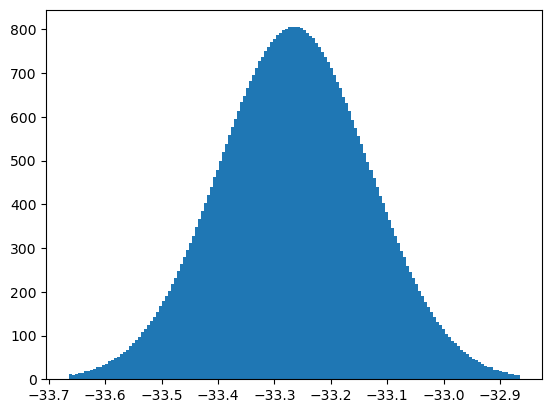

In [146]:
plt.hist(eval_pts, bins=150)
plt.show()

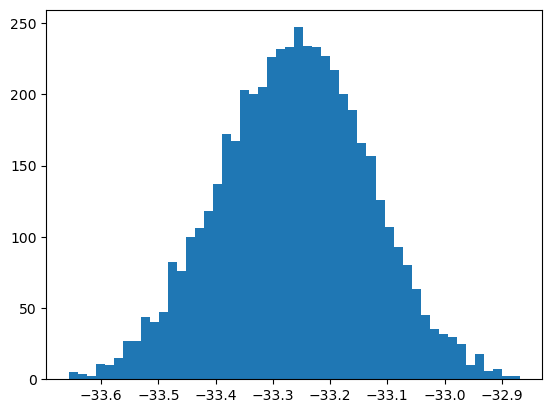

In [164]:
i=9
num_tasks = 140*36
plt.hist(eval_pts[i*num_tasks:(i+1)*num_tasks], bins=50)
plt.show()

### Peak current bin test

In [38]:
uid = xopt_out['Unique ID'].iloc[0]
loc = 'PENT'
P   = pmd_beamphysics.ParticleGroup(f'{directory}/{uid}/{loc}.h5')

In [64]:
bins = [(i+1) for i in range(10)] \
    + [(i+1)*5 for i in range(10)] \
    + [(i+1)*10 for i in range(10)] \
    + [(i+1)*50 for i in range(10)] \
    + [(i+1)*100 for i in range(10)] \
    + [(i+1)*500 for i in range(10)] \
    + [(i+1)*1000 for i in range(10)]

# peak_current = np.zeros(len(bins))
peak_current = {}
for i in range(len(bins)):
    peak_current[bins[i]] = P.slice_statistics(slice_key='t', n_slice=bins[i])['current'].max() * 1e-3

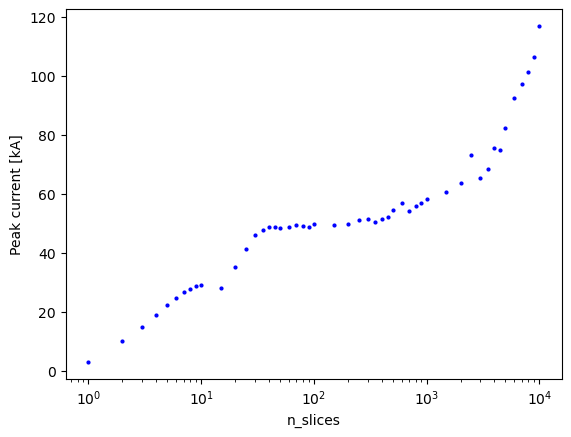

In [65]:
plt.scatter(peak_current.keys(), peak_current.values(), s=4, color='b')
plt.xscale('log')
plt.xlabel('n_slices')
plt.ylabel('Peak current [kA]')
plt.show()

# Visualize results

### Compute time

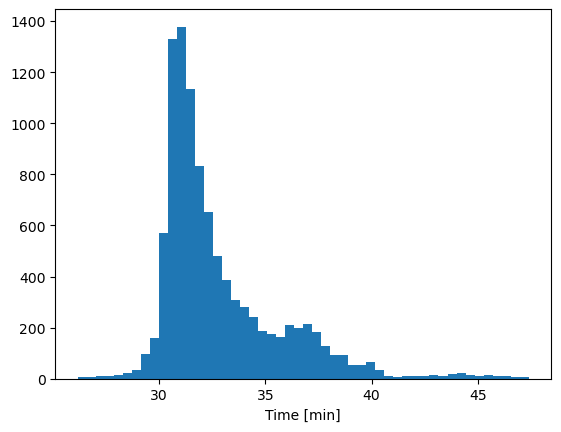

In [6]:
plt.hist(xopt_out['xopt_runtime']/60, bins=50)
plt.xlabel('Time [min]')
plt.show()

### Summary plots

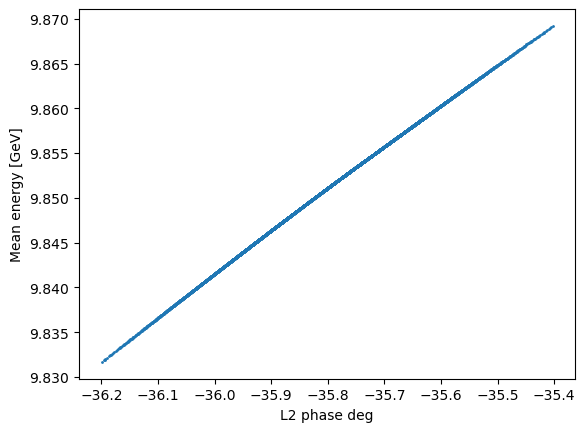

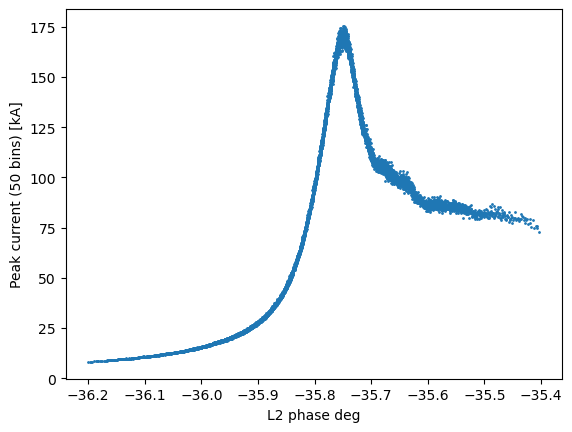

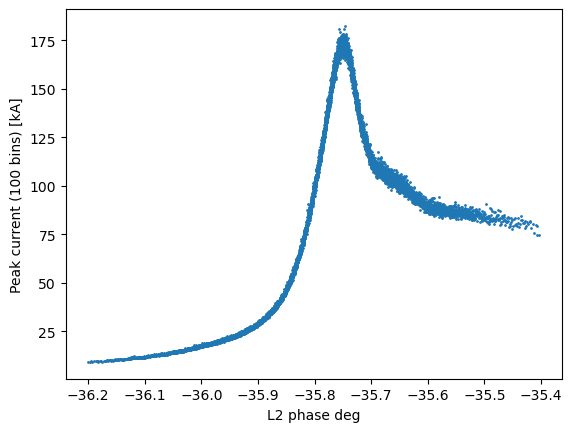

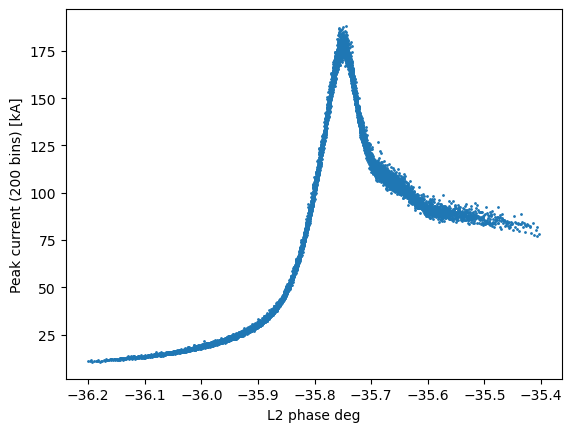

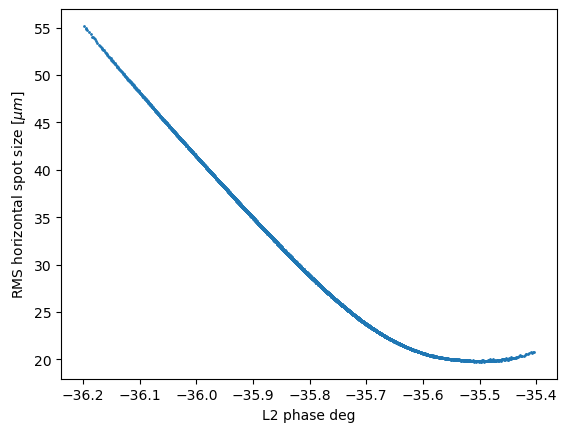

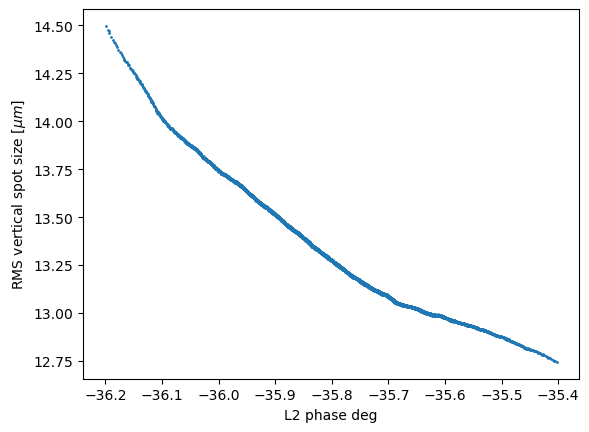

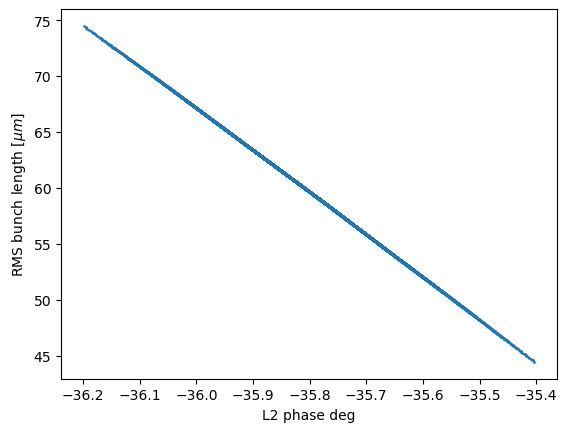

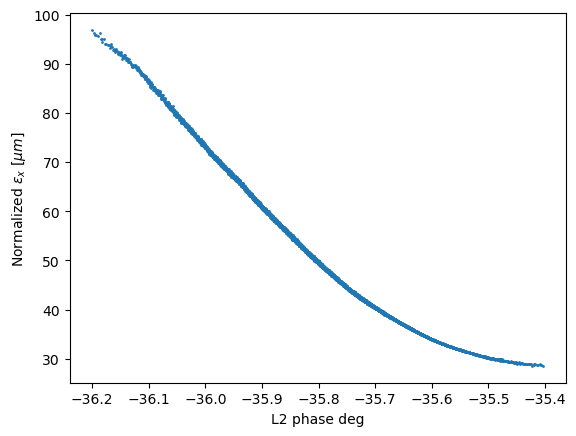

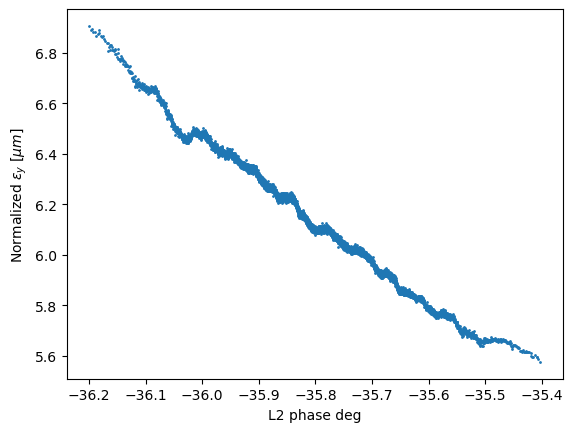

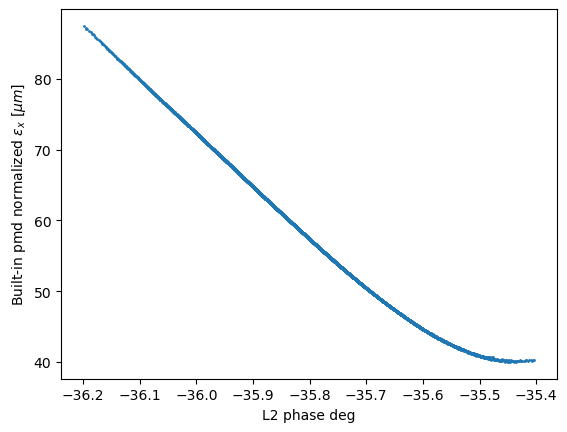

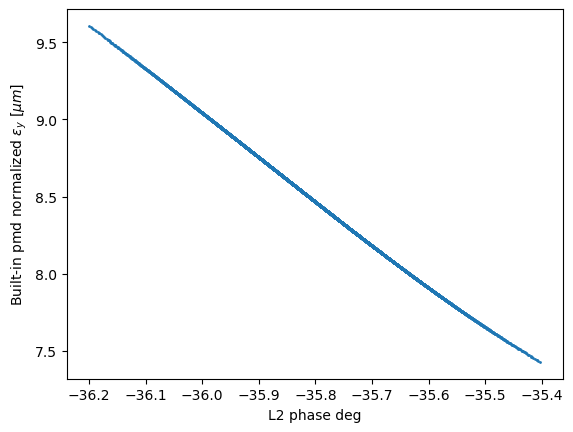

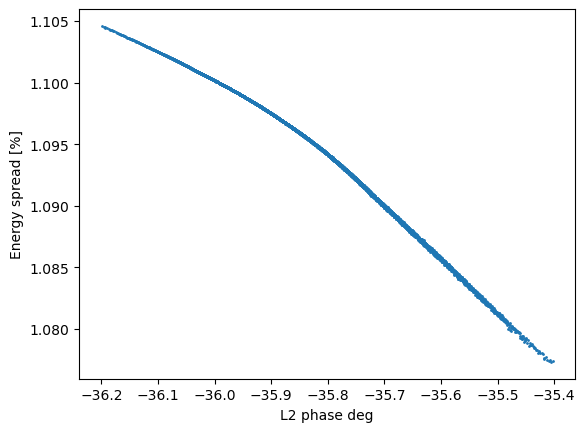

In [7]:
location = 'PENT'

for key in key_label_dict.keys():
    plt.scatter(xopt_out['L2PhaseSet'],
                gather_diagnostics(location),
                s=1
               )
    plt.xlabel('L2 phase deg')
    plt.ylabel(key_label_dict[key])
    
    if key == 'peak current':
        plt.yscale('log')
    
    plt.show()

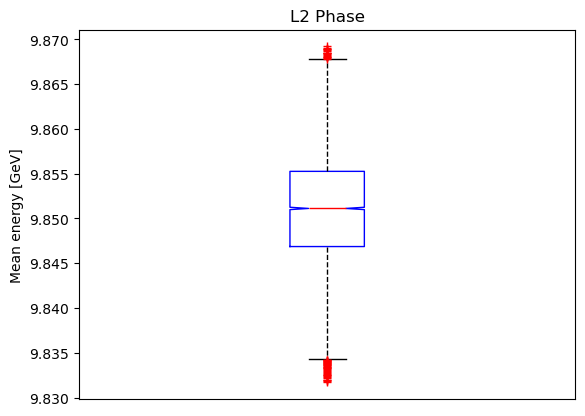

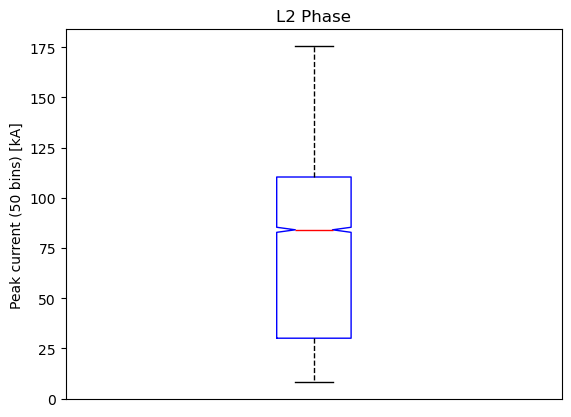

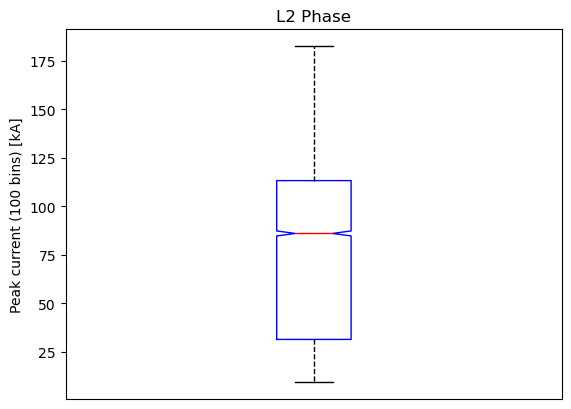

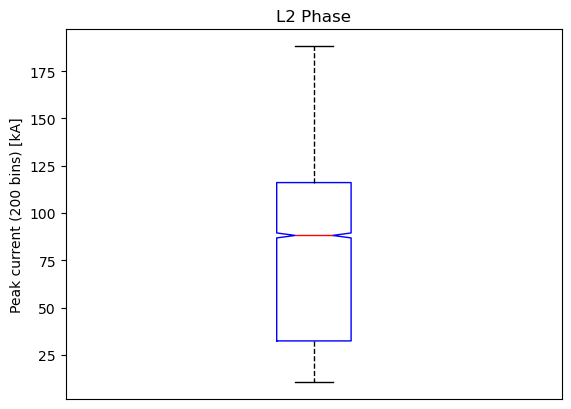

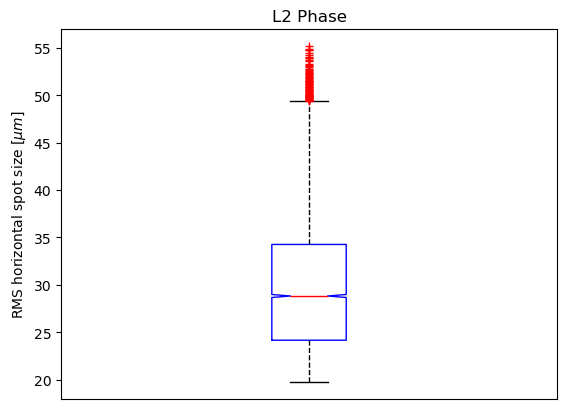

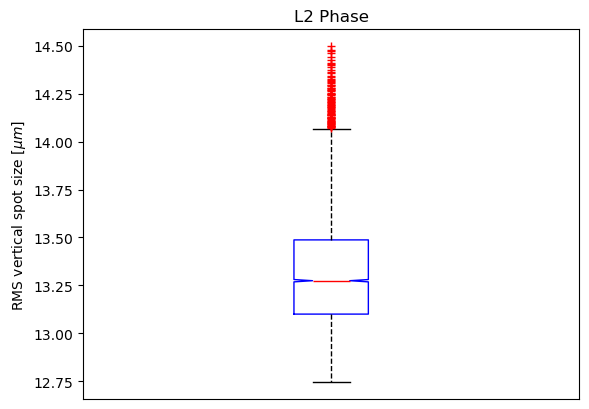

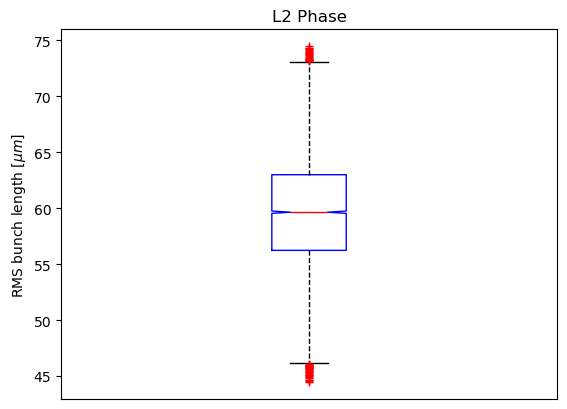

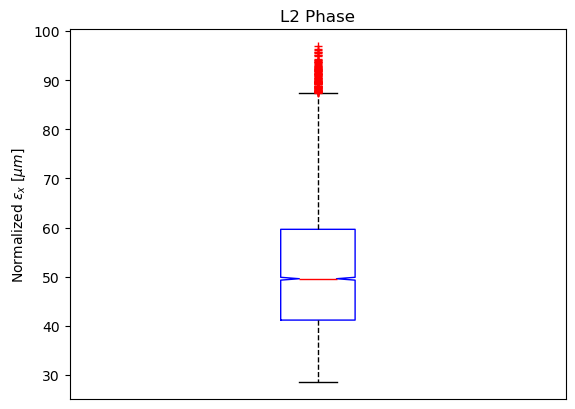

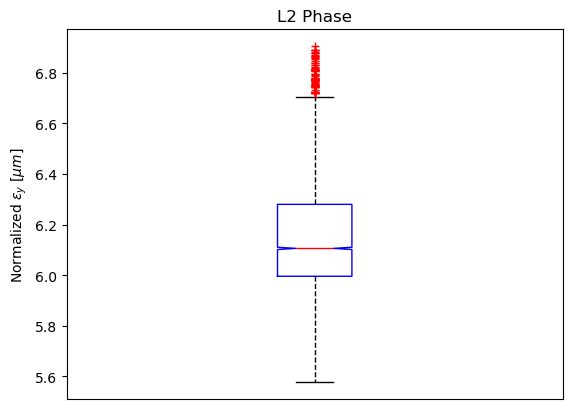

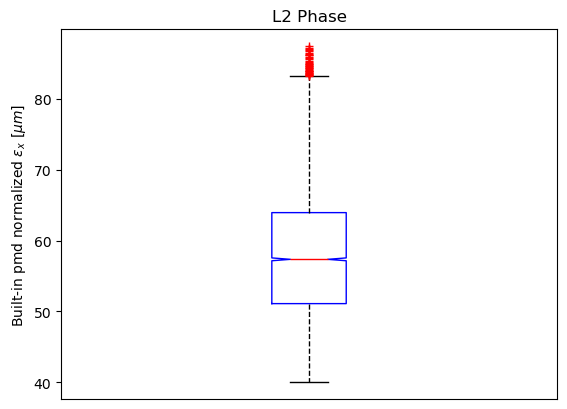

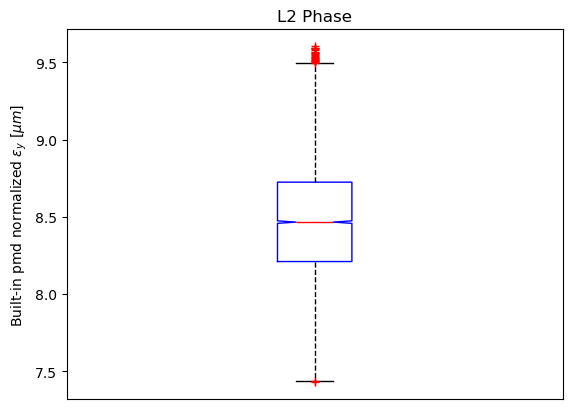

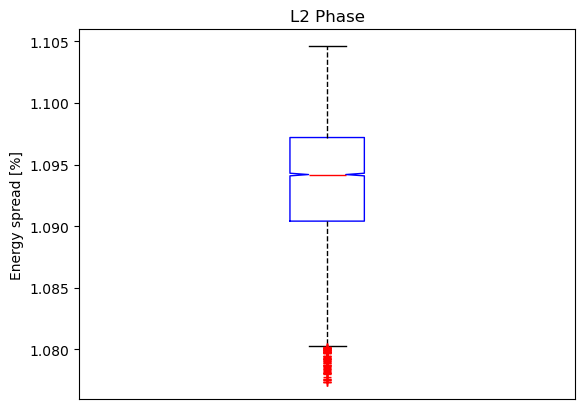

In [8]:
location = 'PENT'

for key in key_label_dict.keys():
    TDRBoxPlot(
        # key,
        gather_diagnostics(location)
    )
    # plt.xlabel(jitter_file_str)
    plt.ylabel(key_label_dict[key])
    plt.xticks([])
    plt.title('L2 Phase')
    plt.show()

# Statistical convergence

In [9]:
def stat_convergence(diags, key, location='PENT', factor=3, plot=False, return_data=False):
    sample_sizes = [ int(len(diags) / 10**(i/factor)) for i in range(factor * int(np.log10(len(diags))) + 1) ]
    samples      = [ random.sample(list(diags.keys()), k=sample_size) for sample_size in sample_sizes ]

    if plot:
        plot_data = [ [ diags[sample][location][key] * key_scale_dict[key] for sample in samples[i] ] for i in range(len(samples)) ]
        
        # Adjust widths for log scale
        log_sample_sizes = np.log10(sample_sizes)
        width_ratios = np.diff(log_sample_sizes)
        widths = np.concatenate((width_ratios, [width_ratios[-1]]))  # Add one more width ratio for the last plot
        
        TDRBoxPlot(plot_data, positions=sample_sizes, widths=np.divide(sample_sizes, 2))
        plt.xscale('log')
        # plt.gca().invert_xaxis()
        plt.xlabel('Sample size')
        plt.ylabel(key_label_dict[key])


        
        plt.show()
    
    if return_data:
        means  = [ np.mean([ diags[sample][location][key] * key_scale_dict[key] for sample in samples[i] ]) for i in range(len(samples)) ]
        sigmas = [ np.std([ diags[sample][location][key] * key_scale_dict[key] for sample in samples[i] ]) for i in range(len(samples)) ]
        
        return means, sigmas, samples

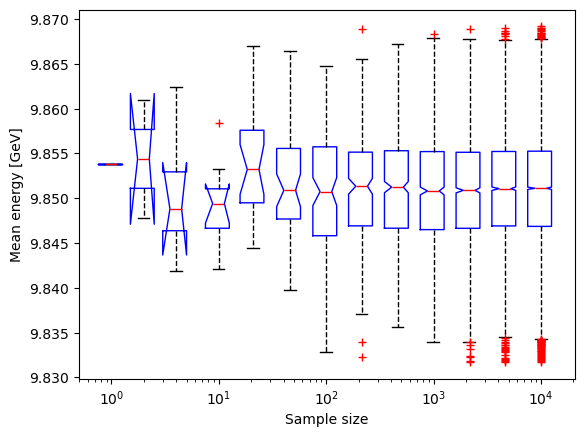

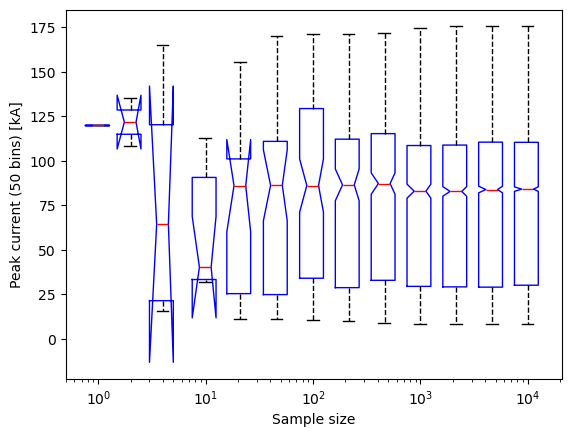

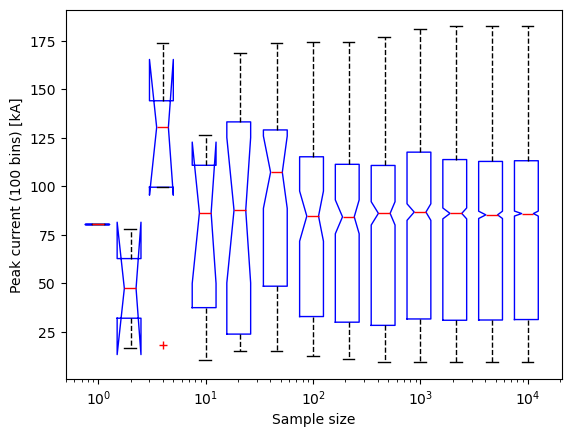

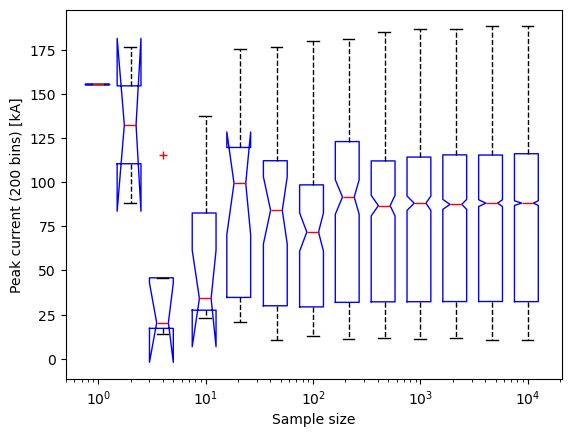

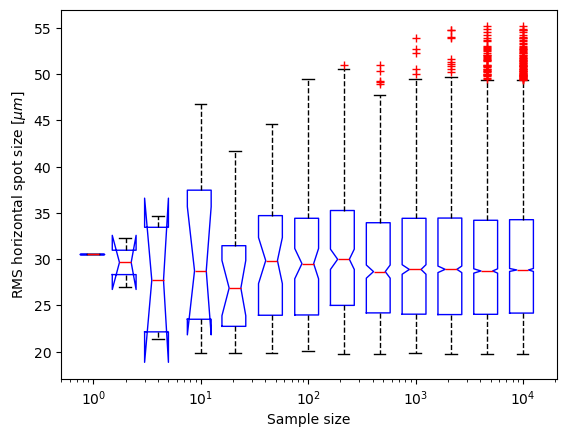

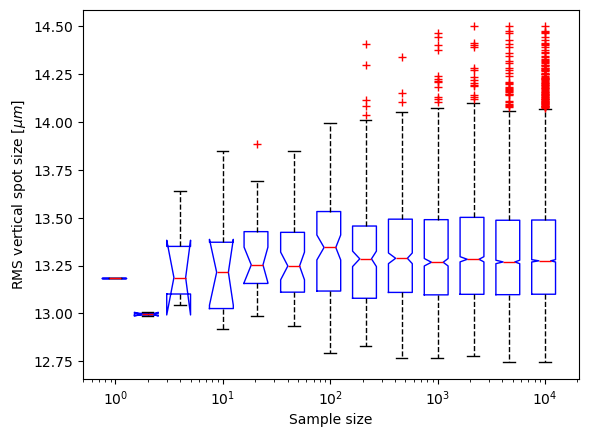

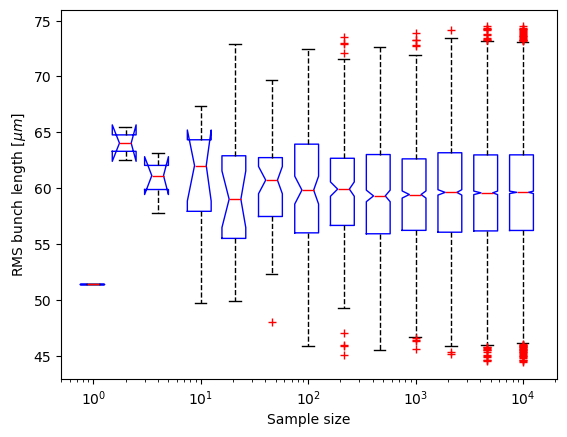

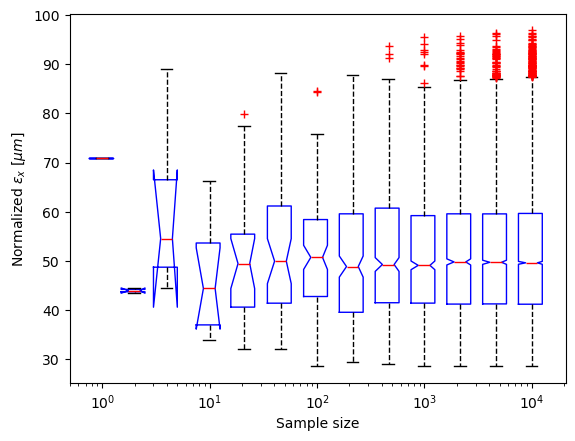

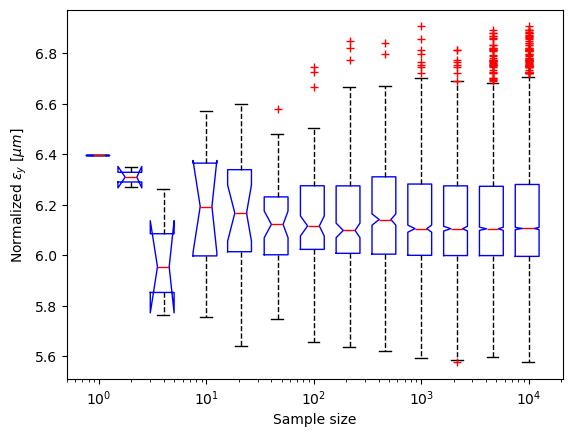

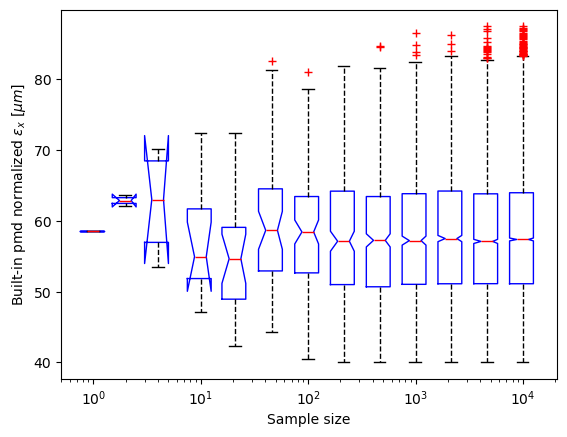

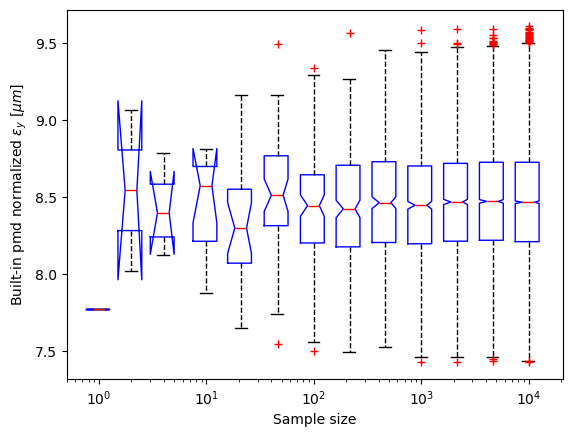

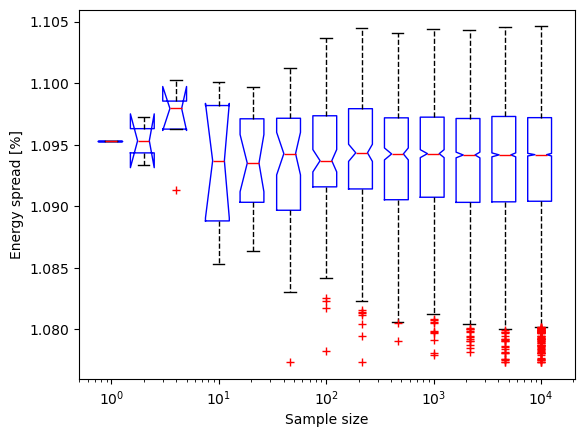

In [10]:
for key in key_label_dict.keys():
    stat_convergence(diagnostics, key, plot=True, return_data=False)

# Start-to-end with nominal values (convergence scan)

For macro particle vs impact-T resolution, starting heuristic:
$$\textrm{number of macroparticles} = 5 \textrm{ macroparticles per cell} \implies 5 \cdot N_x \cdot N_y \cdot N_z$$

### Define helper functions and presets

In [14]:
compare_energy    = {'ENDINJ': 125e6, 'BC11CEND': 335e6, 'ENDBC14_2': 4.5e9, 'ENDFF20': 1e10}
compare_z         = {'ENDINJ': 557e-6, 'BC11CEND': 339e-6, 'ENDBC14_2': 24e-6, 'ENDFF20': 7.6e-6}
compare_emittance = {'ENDINJ': {'x': 3.6e-6, 'y': 2.7e-6}, 'ENDL3F_2': {'x': 7.1e-6, 'y': 4.6e-6}}
compare_e_spread  = {'ENDINJ': 0.1e-2, 'BC11CEND': 0.5e-2, 'ENDBC14_2': 1e-2, 'ENDFF20': 0.9e-2}

# path_conda = '/global/common/software/m4272/conda/xopt2/bin/'
path_conda = '/global/homes/m/maxvarv/miniforge3/envs/bmad/bin/'

def convergenceScan(output_path: str, Nx: int, scl: int, locations = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'], results = True, **kwargs):
    
    tao = initializeTao(
        inputBeamFilePathSuffix = importedDefaultSettings['inputBeamFilePathSuffix'],
        impactGridCount = Nx,
        csrTF = True,
        numMacroParticles = scl * Nx**3,
        runImpactTF = False,
        GFILESuffix = '2024-10-22_distgen_onebunch.yaml',
        solenoidTValue = -0.41,
        L0APhaseOffset = 0,
        command = path_conda + 'ImpactTexe',    
        command_mpi = path_conda + 'ImpactTexe-mpi',
        mpi_run = '/global/u1/m/maxvarv/miniforge3/envs/bmad/bin/mpirun --map-by :OVERSUBSCRIBE -n {nproc} {command_mpi}',
        # mpi_run = '/global/u1/m/maxvarv/miniforge3/envs/Multifidelity/bin/mpirun --map-by :OVERSUBSCRIBE -n {nproc} {command_mpi}',
        **kwargs
    )
    
    setLattice(tao, **importedDefaultSettings)
    trackBeam(tao, **importedDefaultSettings)
    
    return resultsFromScan(tao, output_path, Nx, scl, locations, True, results)



def resultsFromScan(tao, output_path: str, Nx: int, scl: int, locations: list, write: bool, results: bool = True):
    N = len(locations)

    results = {
                'location'       : locations,
                'energy'         : np.zeros(N),
                'energy spread'  : np.zeros(N),
                'peak current'   : np.zeros(N),
                'sigma_z'        : np.zeros(N),
                'emittance_x'    : np.zeros(N),
                'emittance_y'    : np.zeros(N),
                'pmd_emittance_x': np.zeros(N),
                'pmd_emittance_y': np.zeros(N)
              }
    
    for idx,location in enumerate(locations):
        
        directory = f"{output_path}/{Nx}_{scl}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        if write:
            # write to output_path
            pts = getBeamAtElement(tao, location)
            pts.write(f"{directory}/{location}.h5")
        else:
            # read from output_path
            pts = pmd_beamphysics.ParticleGroup(f"{directory}/{location}.h5")
            
        if results:
            results['energy'         ][idx] = pts.avg('energy')
            results['energy spread'  ][idx] = pts.std('energy')/pts.avg('energy')
            results['peak current'   ][idx] = pts.slice_statistics(slice_key='t', n_slice=200)['current'].max()
            results['sigma_z'        ][idx] = smallestIntervalImpliedSigma(pts.z)
            results['emittance_x'    ][idx] = smallestIntervalImpliedEmittance(pts, plane = "x", percentage = 0.9)
            results['emittance_y'    ][idx] = smallestIntervalImpliedEmittance(pts, plane = "y", percentage = 0.9)
            results['pmd_emittance_x'][idx] = pts.norm_emit_x
            results['pmd_emittance_y'][idx] = pts.norm_emit_y
    
    return results

def pmdResultsFromScan(output_path: str, Nx: int, scl: int, location: list):

    directory = f"{output_path}/{Nx}_{scl}"    
    
    # read from output_path
    pts = pmd_beamphysics.ParticleGroup(f"{directory}/{location}.h5")

    return pts

def plotScan(results_dict: dict, quantity: str, show: bool = True):
    sz = 16
    plt.xticks(rotation=60)
    legend_list = []

    count = len(results_dict)
    for key,val in results_dict.items():
        plt.scatter(val['location'], val[quantity] * key_scale_dict[quantity], s=sz * count/len(results_dict), edgecolors='k', linewidth=0.25)
        # legend_list.append(r'$N_x = N_y = N_z = $' + f'{key}')
        legend_list.append(f'Scale = {key}')
        
        # count -= 1 # comment this line if you want the scatter point size to remain constant across each simulation being plotted

    plt.ylabel(key_label_dict[quantity])
    # plt.legend(legend_list)
    plt.legend(legend_list, title=r'$N_{\mathrm{macro}} = \mathrm{scale}\,\cdot 32^3$', title_fontsize=12)
    
    if show:
        plt.show()

### Number of grid cells scan

In [6]:
results_dict = {}

# convergenceScan('/pscratch/sd/m/maxvarv/ConvergenceScan', Nx=64, scl=5)

for Nx in [8, 16, 32, 64]:
#     results_dict[Nx] = convergenceScan('/pscratch/sd/m/maxvarv/ConvergenceScan', Nx=Nx, scl=5)
    results_dict[Nx] = resultsFromScan('',
                                       output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan',
                                       Nx          = Nx,
                                       scl         = 5,
                                       locations   = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'],
                                       write       = False)

/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:446: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)
/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:477: RuntimeWarning: invalid value encountered in sqrt
  emit_opt = np.sqrt( sigmax_opt**2 * sigmaxp_opt**2 - (rho_opt * sigmax_opt * sigmaxp_opt)**2 )


In [6]:
results_dict = {}

# for Nx in [64]:
#     importedDefaultSettings['inputBeamFilePathSuffix'] = f'/beams/ImpactBeam{Nx}_5.h5'
#     results_dict[Nx] = convergenceScan('/pscratch/sd/m/maxvarv/NewConvergenceScan', Nx=Nx, scl=5)

results_dict[32] = resultsFromScan('',
                                   output_path = '/pscratch/sd/m/maxvarv/NewConvergenceScan',
                                   Nx          = 32,
                                   scl         = 5,
                                   locations   = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'],
                                   write       = False)

/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:464: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


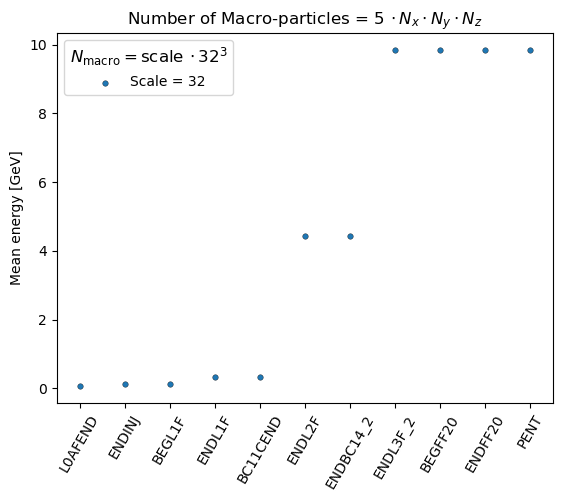

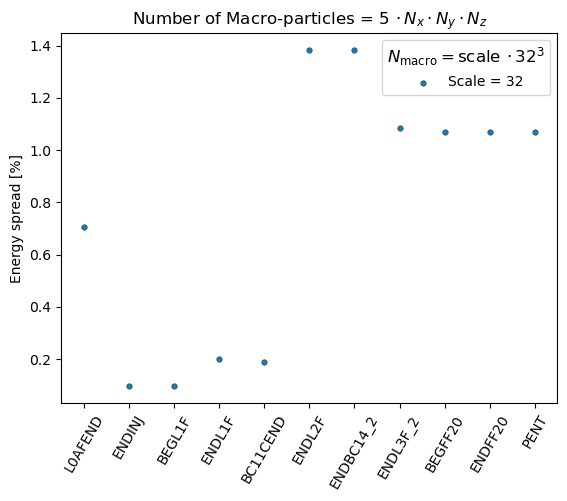

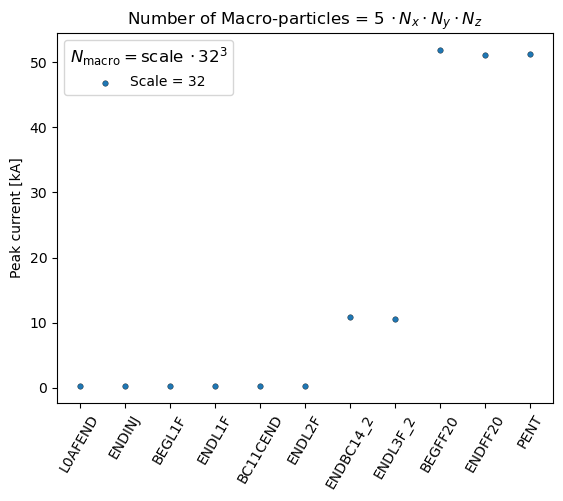

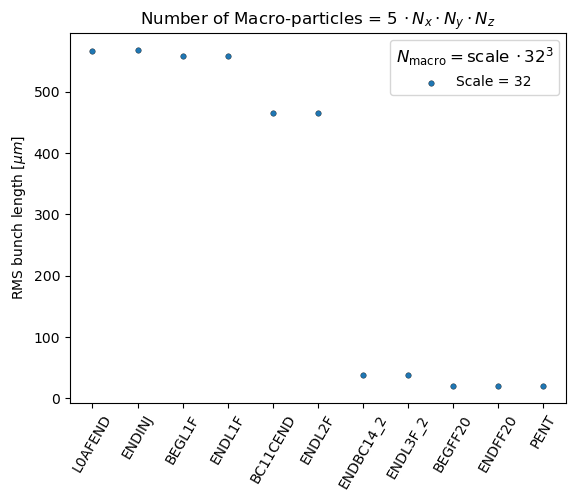

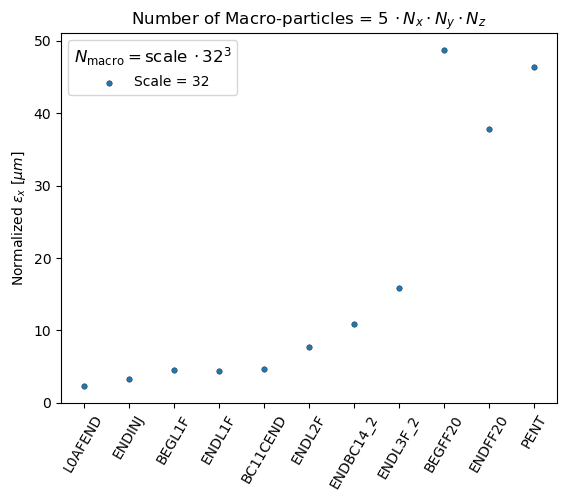

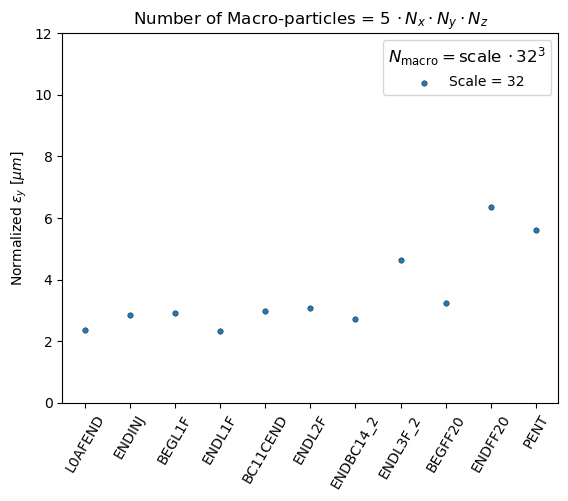

In [7]:
# for scanning Nx,Ny,Nz

scl = 5

for key in results_dict[32]: # just for getting `locations`
    if key != 'location':
        plotScan(results_dict, quantity=key, show=False)
        plt.title(f'Number of Macro-particles = {scl}' + r'$\,\cdot N_x \cdot N_y \cdot N_z$')
        if key == 'emittance_y':
            plt.ylim(0,12)
        plt.show()

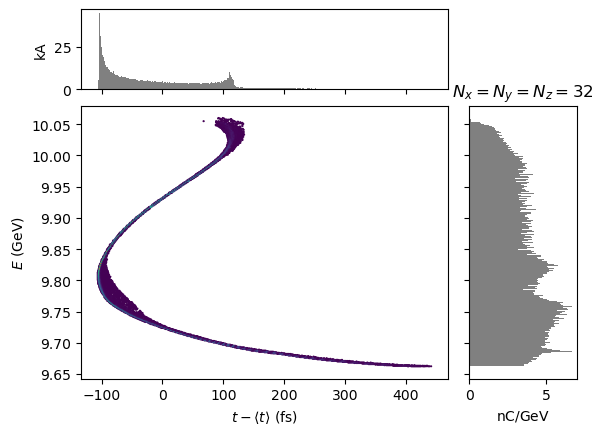

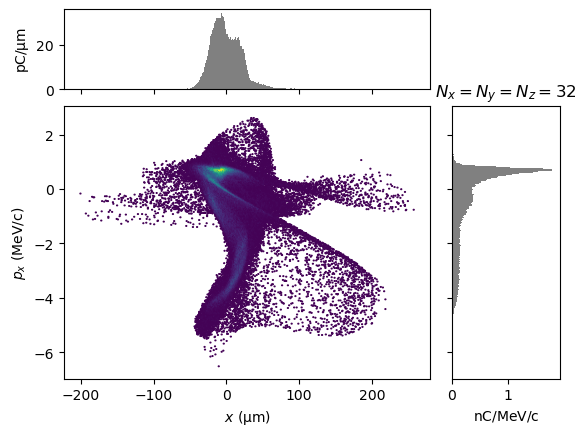

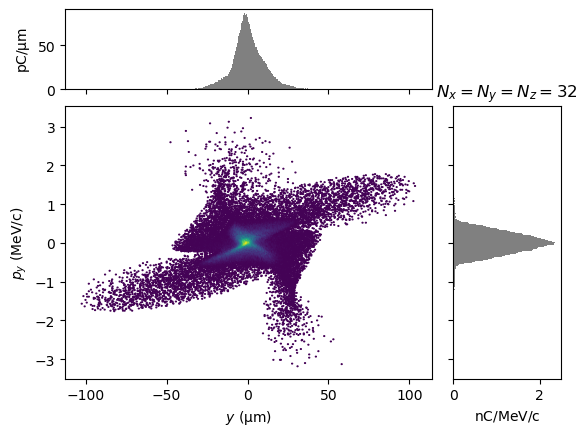

In [8]:
for Nx in [32
           # , 64
          ]:

    pts = pmdResultsFromScan(
        output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan',
        Nx          = Nx,
        scl         = 5,
        location    = 'PENT'
    )
    
    pts.plot('delta_t','energy', bins=400)
    plt.title(r'$N_x=N_y=N_z= $' + f'{Nx}')
    plt.show()
    
    pts.plot('x','px', bins=400)
    plt.title(r'$N_x=N_y=N_z= $' + f'{Nx}')
    plt.show()
    
    pts.plot('y','py', bins=400)
    plt.title(r'$N_x=N_y=N_z= $' + f'{Nx}')
    plt.show()

### Number of macro particles scan

In [11]:
# scl = 5
Nx = 32
scl = [ 1, 2, 4, 5, 8 ]
# scl_done = [ 1, 2, 4, 5 ]
results_dict = {}

# results = {
#                 'location': [],
#                 'energy': np.zeros(11),
#                 'energy spread': np.zeros(11),
#                 'peak current': np.zeros(11),
#                 'blen z': np.zeros(11),
#                 'emittance_x': np.zeros(11),
#                 'emittance_y': np.zeros(11)
#               }

# for s in [8]:
    # results_dict[s] = convergenceScan(output_path='/pscratch/sd/m/maxvarv/ConvergenceScan', Nx=Nx, scl=s)
    # convergenceScan(output_path='/pscratch/sd/m/maxvarv/ConvergenceScan', Nx=32, scl=s)

# for s in scl:
#     convergenceScan(output_path='/pscratch/sd/m/maxvarv/ConvergenceScan', Nx=64, scl=s, results=False)
    
    # if s == 4:
    #     results_dict[5] = resultsFromScan('',
    #                                    output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan',
    #                                    Nx          = Nx,
    #                                    scl         = 5,
    #                                    locations   = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'],
    #                                    write       = False)

for s in scl:
    results_dict[s] = resultsFromScan('',
                                       output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan',
                                       Nx          = Nx,
                                       scl         = s,
                                       locations   = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'],
                                       write       = False)

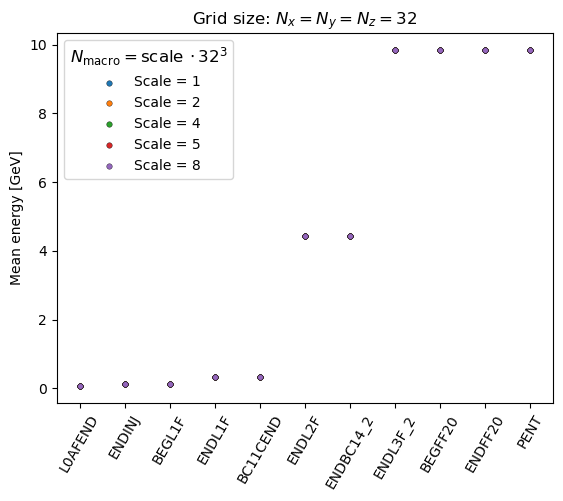

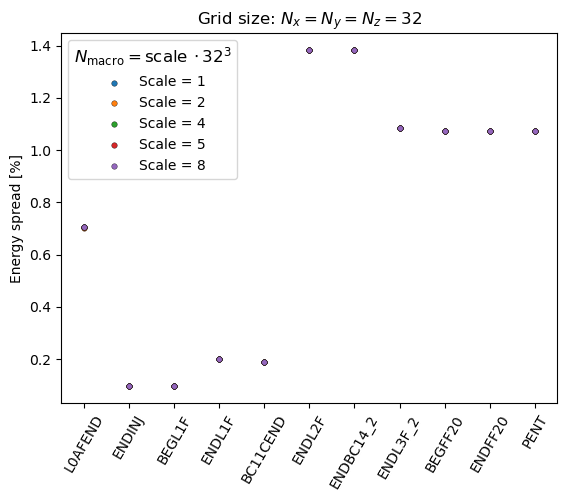

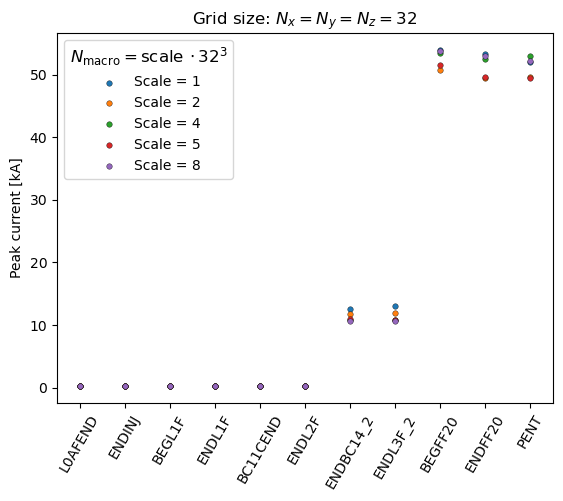

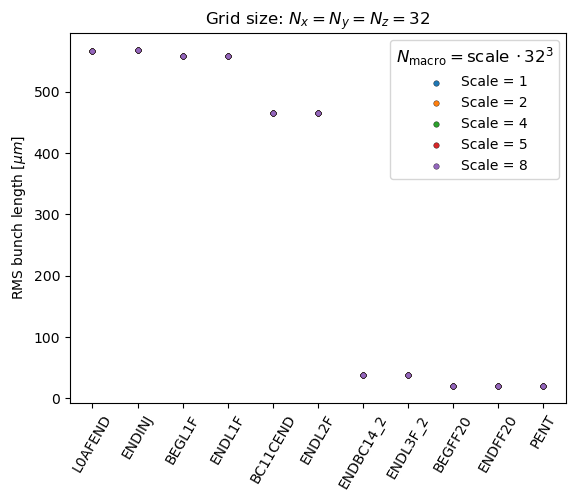

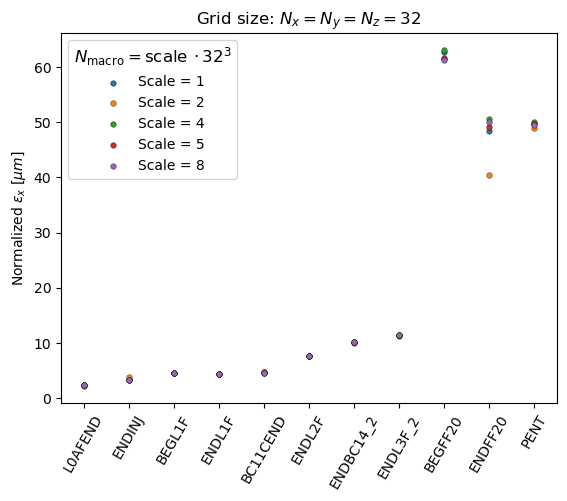

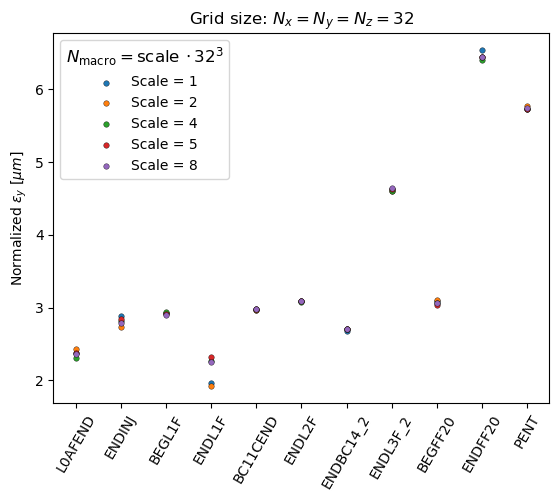

In [12]:
# for scanning number of macro particles

# don't forget to add scl = 5 to results_dict!

for key in results_dict[1]: # just for getting `locations`
    if key != 'location':
        plotScan(results_dict, quantity=key, show=False)
        plt.title(r'Grid size: $N_x = N_y = N_z = 32$')
        plt.show()

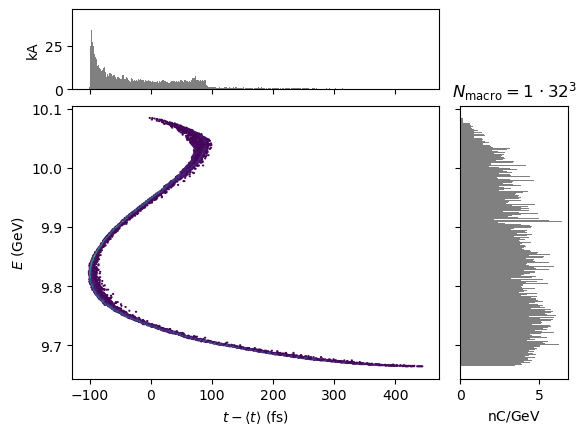

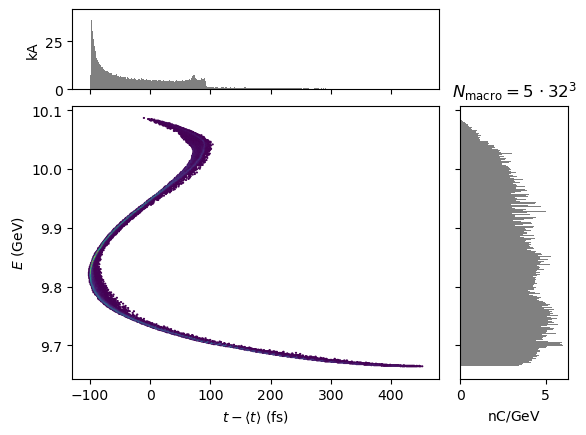

In [13]:
Nx = 32
for s in [1, 5]:

    pts = pmdResultsFromScan(
        output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan',
        Nx          = Nx,
        scl         = s,
        location    = 'PENT'
    )
    
    pts.plot('delta_t','energy', bins=400)
    plt.title(r'$N_{\mathrm{macro}} = $' + f'{s}' + r'$\,\cdot$' f'{Nx}' + r'$^3$')
    plt.show()

### Comparisons to TDR

In [6]:
# currently would need to modify initializeTao() to take ImpactBeamExtName
results = convergenceScan('/pscratch/sd/m/maxvarv/ConvergenceScan', Nx=32, scl=5, ImpactBeamExtName = '32_5')

Environment set to:  /global/u1/m/maxvarv/FACET2-Bmad-PyTao


Installed Tao version is lower than pytao's recommended and tested version. 
   You have Tao version: 2024-09-16
   Recommended version:  2024-11-19
Some features may not work as expected.  Please upgrade bmad.


Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Running Impact
	 Impact: Autophasing
	 Impact: Distgen
	 Impact: Tracking
Running Impact-T in /global/u1/m/maxvarv/FACET2-Bmad-PyTao/impact/tmpsvx1w5ka
/global/homes/m/maxvarv/miniforge3/envs/bmad/bin/ImpactTexe
writing 163840 particles to /global/u1/m/maxvarv/FACET2-Bmad-PyTao/impact/tmpsvx1w5ka/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 163840 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 7.015747117006533e-12 according to initial particles
Cathode start: Replaced Tini with -3.5085417586726863e-12 according to initial particles
Setting total charge to 1.5999999999999996e-09 C
 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code:

/global/u1/m/maxvarv/FACET2-Bmad-PyTao/UTILITY_quickstart.py:446: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


In [ ]:
path_conda = '/global/homes/m/maxvarv/miniforge3/envs/bmad/bin/'
ImpactBeamExtName = '1.6e5_2'

I = runImpact(
    impactGridCount = 32,
    numMacroParticles = 5 * 32**3,
    # GFILESuffix = '../beams/2024-12-11_Impact_OneBunch/Source/impact/2024-10-22_distgen_onebunch.yaml',
    GFILESuffix = '2024-10-22_distgen_onebunch.yaml',
    L0APhaseOffset = 0,
    solenoidTValue = -0.41,
    returnImpactObject = True,
    command = path_conda + 'ImpactTexe',    
    command_mpi = path_conda + 'ImpactTexe-mpi',
    mpi_run = '/global/u1/m/maxvarv/miniforge3/envs/bmad/bin/mpirun --map-by :OVERSUBSCRIBE -n {nproc} {command_mpi}',
    ImpactBeamExtName = ImpactBeamExtName,
)

In [7]:
# P = I.particles['L0AFEND'].copy()
# P = ParticleGroup(f"./beams/ImpactBeam.h5")
P = ParticleGroup(f"./beams/ImpactBeam32_5.h5")
# P = ParticleGroup(f"./beams/ImpactBeam{ImpactBeamExtName}.h5")
# P = ParticleGroup(f"./beams/ImpactBeam1.6e5_2.h5")
# P = ParticleGroup("./beams/2024-10-22_Impact_OneBunch/2024-10-22_oneBunch.h5")

In [8]:
P.twiss()

{'alpha_x': np.float64(-14.854123926870386),
 'beta_x': np.float64(57.5498242513902),
 'gamma_x': np.float64(3.8513583754249106),
 'emit_x': np.float64(3.5047377351327595e-08),
 'eta_x': np.float64(-3.594364236232958e-06),
 'etap_x': np.float64(-6.534977273264965e-07),
 'norm_emit_x': np.float64(4.706447927209658e-06)}

In [9]:
P["mean_t"]

np.float64(-3.8467031247750556e-24)

In [10]:
P["mean_z"]

np.float64(0.0)

In [41]:
tao = initializeTao(
                    inputBeamFilePathSuffix = '/beams/2024-10-22_Impact_OneBunch/2024-10-22_oneBunch.h5',
                    # inputBeamFilePathSuffix = f'/beams/ImpactBeam{ImpactBeamExtName}.h5',
                    GFILESuffix = '2024-10-22_distgen_onebunch.yaml',
                    csrTF = True,
                    runImpactTF = False,
                )

setLattice(tao, **importedDefaultSettings)
trackBeam(tao, **importedDefaultSettings)

results = resultsFromScan(
                            tao,
                            output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan',
                            Nx          = 32, # it was really 100 though since it's inherited from '/beams/2024-10-22_Impact_OneBunch/2024-10-22_oneBunch.h5'
                            scl         = '1e5_oneBunch',
                            locations   = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'],
                            write       = True
                         )

Environment set to:  /global/u1/m/maxvarv/FACET2-Bmad-PyTao


Installed Tao version is lower than pytao's recommended and tested version. 
   You have Tao version: 2024-09-16
   Recommended version:  2024-11-19
Some features may not work as expected.  Please upgrade bmad.


Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles defined by input file


In [16]:
results = resultsFromScan(
                            '',
                            output_path = '/pscratch/sd/m/maxvarv/Check_32_5_against_2024-22-10_oneBunch/',
                            Nx          = 32,
                            scl         = 5, #'1e5_oneBunch', #'5_old', #'1e5_oneBunch', #3.05,
                            locations   = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'],
                            write       = False
                         )

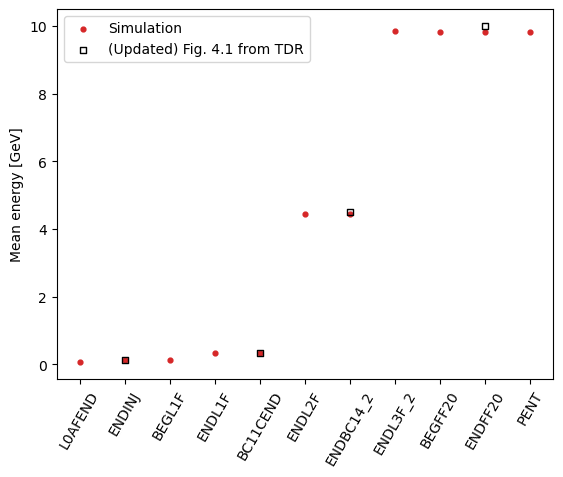

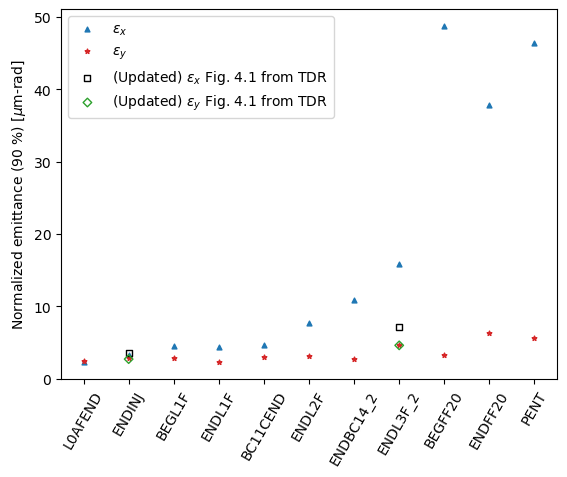

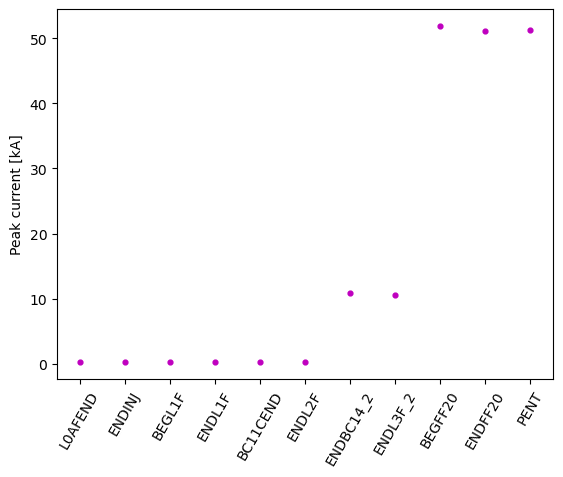

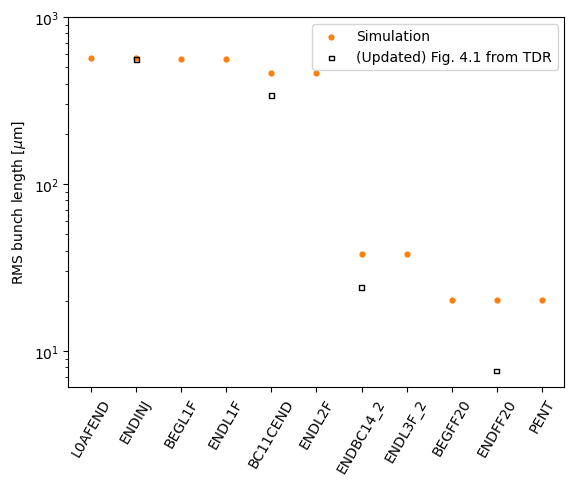

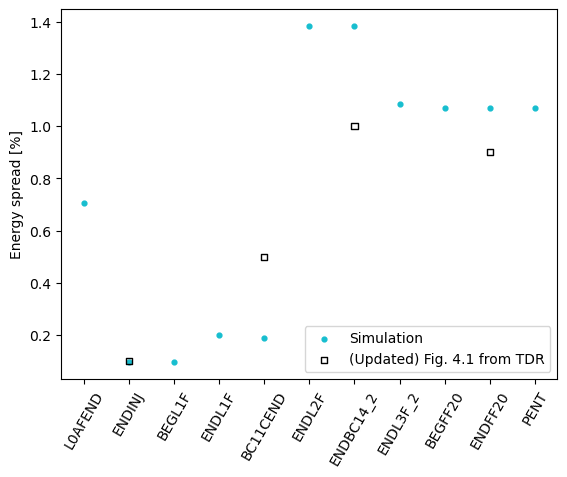

In [10]:
sz = 12

plt.xticks(rotation=60)
plt.scatter(results['location'], results['energy']*1e-9, s=sz, c='tab:red')
plt.scatter([key for key in compare_energy.keys()], [val*1e-9 for val in compare_energy.values()], s=sz+7, marker='s', edgecolors='k', facecolor='none')
plt.ylabel('Mean energy [GeV]')
plt.legend(['Simulation','(Updated) Fig. 4.1 from TDR'])
plt.show()

plt.xticks(rotation=60)
plt.scatter(results['location'], results['emittance_x']*1e6, s=sz, c='tab:blue', marker='^')
plt.scatter(results['location'], results['emittance_y']*1e6, s=sz, c='tab:red', marker='*')
plt.scatter([key for key in compare_emittance.keys()], [val['x']*1e6 for val in compare_emittance.values()], s=sz+7, marker='s', edgecolors='k', facecolor='none')
plt.scatter([key for key in compare_emittance.keys()], [val['y']*1e6 for val in compare_emittance.values()], s=sz+7, marker='D', edgecolors='tab:green', facecolor='none')
plt.legend([r'$\varepsilon_x$',r'$\varepsilon_y$',r'(Updated) $\varepsilon_x$ Fig. 4.1 from TDR',r'(Updated) $\varepsilon_y$ Fig. 4.1 from TDR'])
plt.ylabel(r'Normalized emittance (90 %) [$\mu$m-rad]')
plt.show()

plt.xticks(rotation=60)
plt.scatter(results['location'], results['peak current']*1e-3, s=sz, c='m')
plt.ylabel('Peak current [kA]')
plt.show()

plt.xticks(rotation=60)
plt.scatter(results['location'], results['sigma_z']*1e6, s=sz, c='tab:orange')
plt.scatter([key for key in compare_z.keys()], [val*1e6 for val in compare_z.values()], s=sz, marker='s', edgecolors='k', facecolor='none')
plt.ylabel(r'RMS bunch length [$\mu$m]')
plt.yscale('log')
plt.yticks([10, 100, 1000])
# plt.legend(['np.std(pts.z)','smallestIntervalImpliedSigma','TDR'])
plt.legend(['Simulation','(Updated) Fig. 4.1 from TDR'])
plt.show()

plt.xticks(rotation=60)
plt.scatter(results['location'], results['energy spread']*1e2, s=sz, c='tab:cyan')
plt.scatter([key for key in compare_e_spread.keys()], [val*1e2 for val in compare_e_spread.values()], s=sz+7, marker='s', edgecolors='k', facecolor='none')
plt.ylabel(r'Energy spread [%]')
plt.legend(['Simulation','(Updated) Fig. 4.1 from TDR']
           # , loc='upper left'
          )
plt.show()

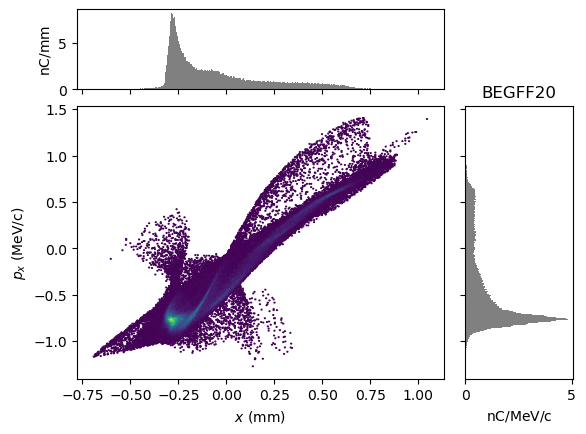

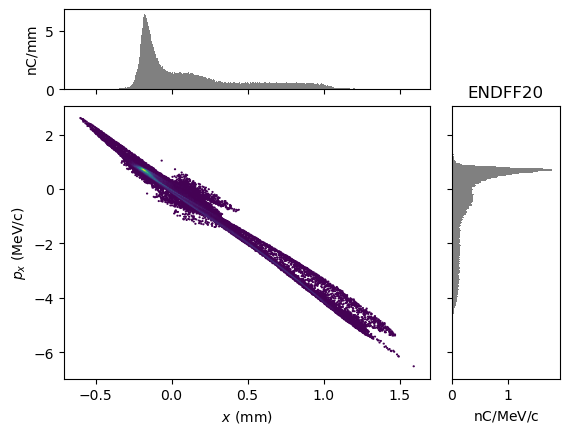

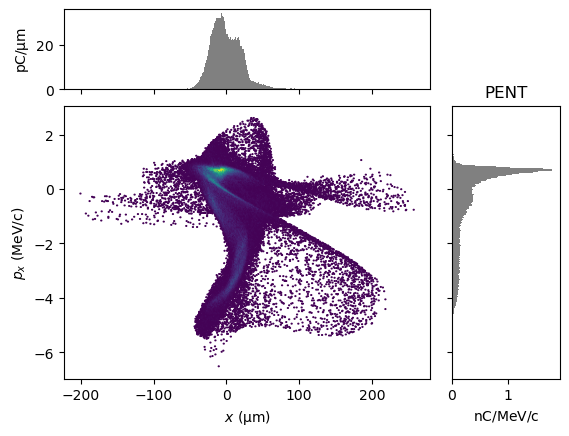

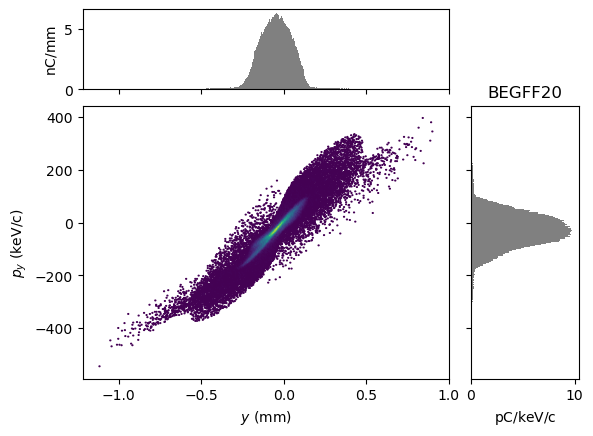

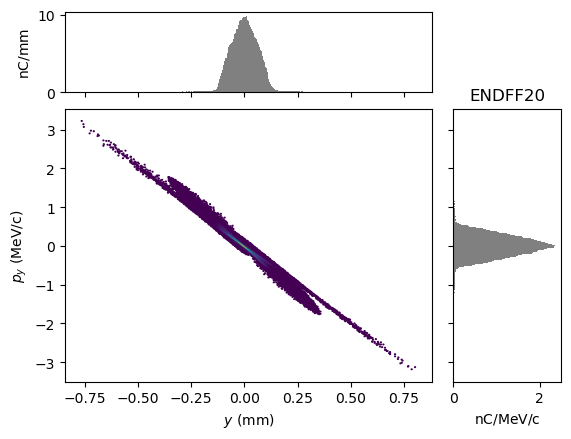

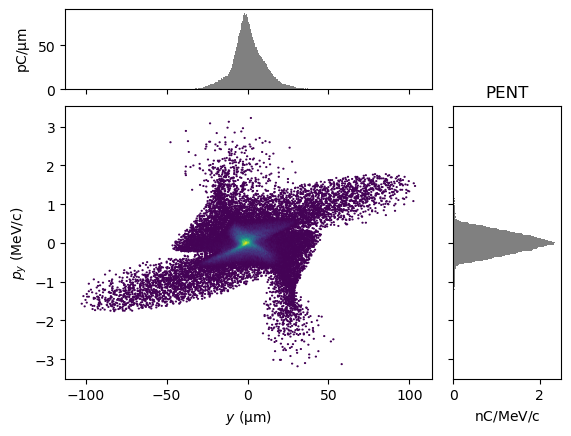

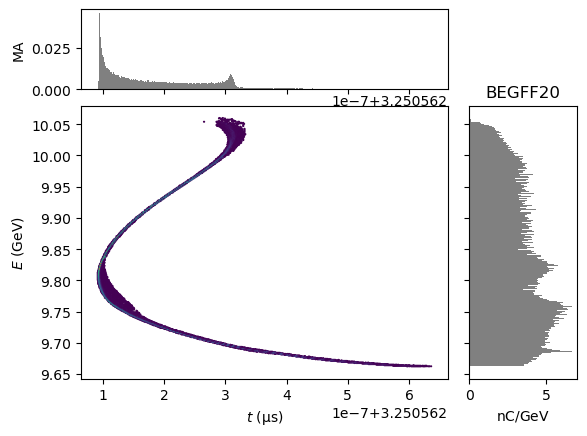

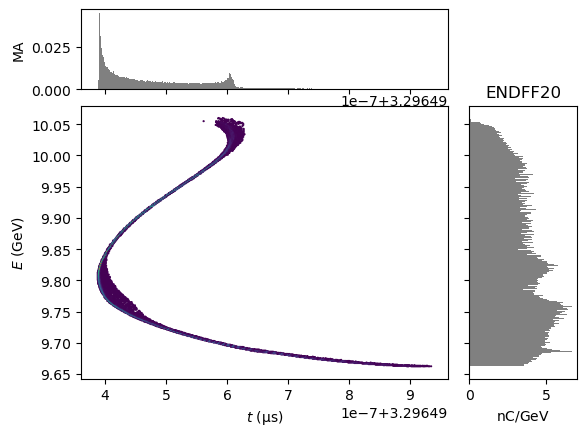

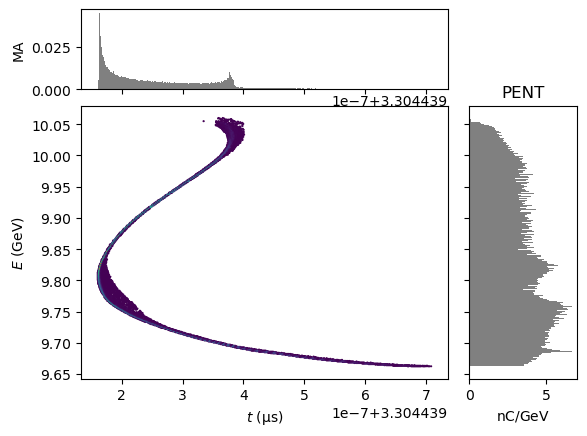

In [18]:
for location in ['BEGFF20','ENDFF20','PENT']:
    pts = pmdResultsFromScan(
        output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan',
        Nx          = 32,
        scl         = 5,
        location    = location
    )
    pts.plot('x','px', bins=400)
    plt.title(location)
    plt.show()

for location in ['BEGFF20','ENDFF20','PENT']:
    pts = pmdResultsFromScan(
        output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan',
        Nx          = 32,
        scl         = 5,
        location    = location
    )
    pts.plot('y','py', bins=400)
    plt.title(location)
    plt.show()

for location in ['BEGFF20','ENDFF20','PENT']:
    pts = pmdResultsFromScan(
        output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan',
        # output_path = '/pscratch/sd/m/maxvarv/Check_32_5_against_2024-22-10_oneBunch/',
        Nx          = 32,
        scl         = 5,
        location    = location
    )
    pts.plot('t','energy', bins=400)
    plt.title(location)
    plt.show()

### Comparing $10^5$ vs $5\cdot 32^3$ macro partcle impact-T simulation emittances

In [15]:
results1b = resultsFromScan(
                            '',
                            output_path = '/pscratch/sd/m/maxvarv/NewConvergenceScan/',
                            Nx          = 32,
                            scl         = 5, #'5_old', #'1e5_oneBunch', #3.05,
                            locations   = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'],
                            write       = False
                         )

results325 = resultsFromScan(
                            '',
                            output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan/',
                            Nx          = 32,
                            scl         = 5, #'1e5_oneBunch', #3.05,
                            locations   = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'],
                            write       = False
                         )

In [6]:
results1b = resultsFromScan(
                            '',
                            output_path = '/pscratch/sd/m/maxvarv/Check_32_5_against_2024-22-10_oneBunch/',
                            Nx          = 32,
                            scl         = '1e5_oneBunch', #'5_old', #'1e5_oneBunch', #3.05,
                            locations   = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'],
                            write       = False
                         )

results325 = resultsFromScan(
                            '',
                            output_path = '/pscratch/sd/m/maxvarv/ConvergenceScan/',
                            Nx          = 32,
                            scl         = 5, #'1e5_oneBunch', #3.05,
                            locations   = ['L0AFEND','ENDINJ','BEGL1F','ENDL1F','BC11CEND','ENDL2F','ENDBC14_2','ENDL3F_2','BEGFF20','ENDFF20','PENT'],
                            write       = False
                         )

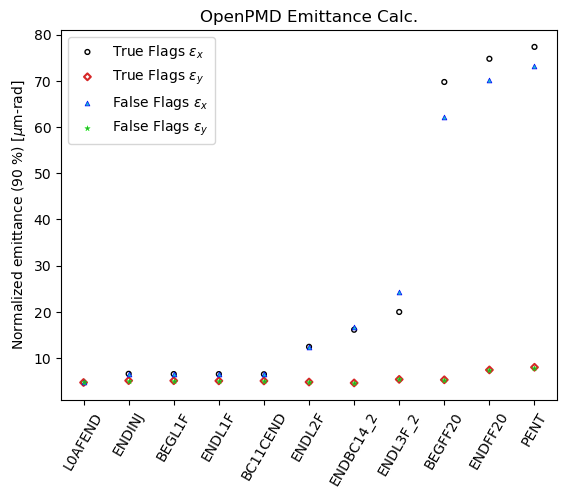

In [16]:
sz = 12

plt.xticks(rotation=60)
plt.scatter(results325['location'], results325['pmd_emittance_x']*1e6, s=sz, edgecolors='k', marker='o', facecolors='None')
plt.scatter(results325['location'], results325['pmd_emittance_y']*1e6, s=sz, edgecolors='tab:red', marker='D', facecolors='None', linewidth=1.5)
plt.scatter(results1b['location'], results1b['pmd_emittance_x']*1e6, s=sz, edgecolors='b', facecolors='tab:cyan', marker='^', linewidth=0.5)
plt.scatter(results1b['location'], results1b['pmd_emittance_y']*1e6, s=sz+5, edgecolors='lime', facecolors='tab:green', marker='*', linewidth=0.25)
# plt.scatter([key for key in compare_emittance.keys()], [val['x']*1e6 for val in compare_emittance.values()], s=sz+7, marker='s', edgecolors='k', facecolor='none')
# plt.scatter([key for key in compare_emittance.keys()], [val['y']*1e6 for val in compare_emittance.values()], s=sz+7, marker='D', edgecolors='tab:green', facecolor='none')

# plt.legend([r'($5\cdot 32^3$ macro) $\varepsilon_x$',r'($5\cdot 32^3$ macro) $\varepsilon_y$',r'($10^5$ macro) $\varepsilon_x$',r'($10^5$ macro) $\varepsilon_y$'])
plt.legend([r'True Flags $\varepsilon_x$',r'True Flags $\varepsilon_y$',r'False Flags $\varepsilon_x$',r'False Flags $\varepsilon_y$'])
plt.ylabel(r'Normalized emittance (90 %) [$\mu$m-rad]')
plt.title('OpenPMD Emittance Calc.')
plt.show()